In [1]:
# Import Packages

In [2]:
import os
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Loading of pre-processed ELA or Noise Residual SRM images along with the lables
# Apart from VidTIMIT-DFTIMIT dataset, for training and evaluation
# only 80,000 real and fake ELA or SRM images are considered 

In [4]:
Encode = {
    'Fake':0,
    'Real':1
}

images = []
labels = []
total_images = 0
for dirs,subdirs,files in os.walk('../srm_data'):      # Path of the ELA or SRM root folder of a Dataset
  cnt = 0
  cnt_img = 0
  for file in files:
    img_path = os.path.join(dirs,file)
    img = Image.open(img_path)
    img = img.resize((128,128))
    img_array = np.asarray(img)
    images.append(img_array)
    st = img_path.split('/')
    # print(st[4])
    cnt_img += 1
    total_images += 1
    labels.append(Encode[st[1]])
    #print(img_path)
    #break
    if total_images >= 160000 or cnt_img == 110:
        break
    if cnt == 80000:
        break
  if total_images >= 160000:
        print(total_images)
        break
print(f'Total Images: {len(images)}')

160000
Total Images: 160000


In [ ]:
# Splitting of Dataset into 80-20 ratio for training and evaluation

In [5]:
images = np.array(images,dtype=np.float32) / 255.0
labels = np.array(labels)
image_train,image_test,y_train,y_test = train_test_split(images,labels,test_size=0.2,random_state=42,)
del images,labels

In [ ]:
# Creation of Single-Branch CNNs from the Dual-Branch architecture for the ablation experiments

In [6]:
def build_model():
  Inputs = tf.keras.Input((128,128,3))
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(Inputs)
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
  x_srm = layers.MaxPooling2D((2, 2))(x_srm)
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
  x_srm = layers.MaxPooling2D((2, 2))(x_srm)

  x_srm = layers.Flatten()(x_srm)
  x_srm = layers.Dense(256, activation='relu')(x_srm)
  x_srm = layers.Dropout(0.5)(x_srm)

  output = layers.Dense(1, activation='sigmoid')(x_srm)
  model = models.Model(inputs=Inputs, outputs=output)
  return model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


2025-07-11 14:21:17.312548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-07-11 14:21:17.364569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2025-07-11 14:21:17.365487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2025-07-11 14:21:17.365672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-07-11 14:21:17.367155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-07-11 14:21:17.3

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0     

In [ ]:
# Custom Callback used to deal with overfitting 
# Saves only those checkpoints where difference between train accuracy and val accuracy is minimum
# Also saves the checkpoints where the val accuracy is better than the previous stored val accuracy

In [9]:
class MinDiffCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_accuracy', prev_val = -10**9 ,min_delta=0.02):
        super(MinDiffCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.min_delta = min_delta      # Minimum acceptable difference
        self.best_diff = np.inf         # Initialize with infinity
        self.best_weights = None
        self.prev_val = prev_val
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # Get current metrics
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        if val_acc is None or train_acc is None:
            return
            
        # Calculate absolute difference
        current_diff = abs(train_acc - val_acc)
        
        # Check if difference is below threshold and better than previous best
        if current_diff < self.min_delta or current_diff < self.best_diff:
            
            # Save the model
            if self.prev_val < val_acc:
                self.prev_val=val_acc
                self.model.save_weights(self.filepath, overwrite=True)
                print(f"\nDifference improved from {self.best_diff:.4f} to {current_diff:.4f}")
                self.best_diff = current_diff
                self.best_weights = self.model.get_weights()
                print(f"Model saved with train-val difference: {current_diff:.4f}")

    def on_train_end(self, logs=None):
        # Restore the best weights found
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"\nTraining complete. Restoring weights with best difference: {self.best_diff:.4f}")

In [10]:
checkpoint = MinDiffCheckpoint(
    filepath='checkPoint_ff_df.keras',       # Name of saved checkpoint
    monitor='val_accuracy',
    min_delta=0.1
)

In [ ]:
# Training of the proposed model

In [11]:
history = model.fit(
        image_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data = (image_test,y_test),
        callbacks = [checkpoint]
    )

2025-07-11 14:21:18.253401: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 25165824000 exceeds 10% of free system memory.


Epoch 1/20


2025-07-11 14:21:27.661958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-07-11 14:21:28.108308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


3999/4000 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8741
Difference improved from inf to 0.0534
Model saved with train-val difference: 0.0534
4000/4000 [==============================] - 126s 31ms/step - loss: 0.2945 - accuracy: 0.8741 - val_loss: 0.1759 - val_accuracy: 0.9274
Epoch 2/20
3999/4000 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9358
Difference improved from 0.0534 to 0.0161
Model saved with train-val difference: 0.0161
4000/4000 [==============================] - 128s 32ms/step - loss: 0.1588 - accuracy: 0.9358 - val_loss: 0.1182 - val_accuracy: 0.9519
Epoch 3/20
4000/4000 [==============================] - 129s 32ms/step - loss: 0.1112 - accuracy: 0.9549 - val_loss: 0.1462 - val_accuracy: 0.9418
Epoch 4/20
3999/4000 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9668
Difference improved from 0.0161 to 0.0024
Model saved with train-val difference: 0.0024
4000/4000 [==========================

In [12]:
model.save('ff_df.keras')            # Saving of the model with best metrics

In [13]:
# Evaluation of the proposed model

In [14]:
model = tf.keras.models.load_model('ff_df.keras')
y_pred_prob = model.predict(image_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

Accuracy: 0.98071875


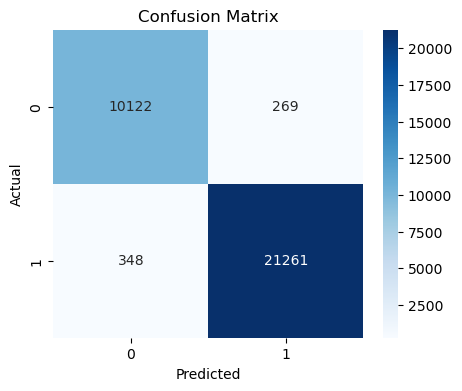

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


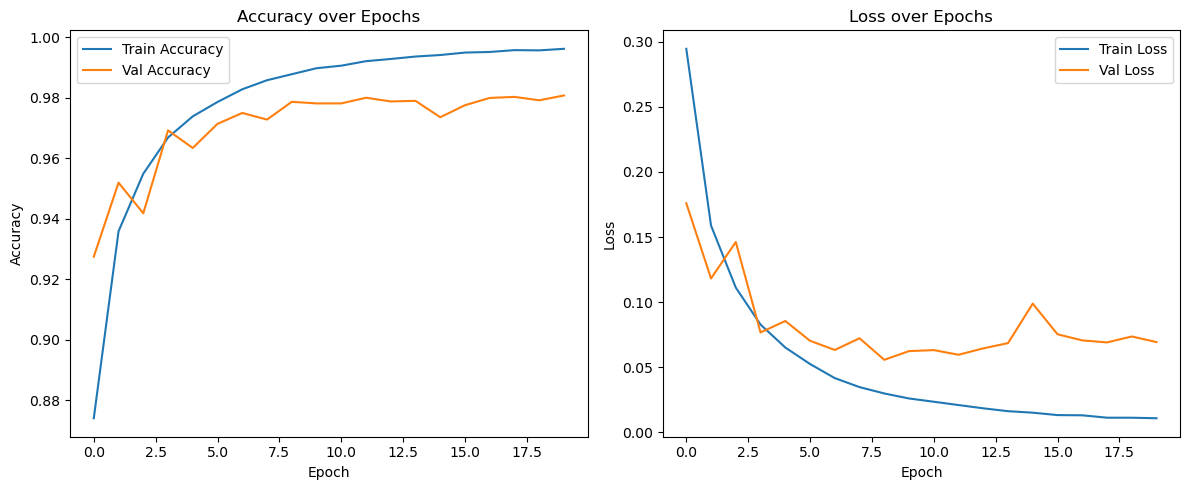

In [16]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

0.9979216717243824


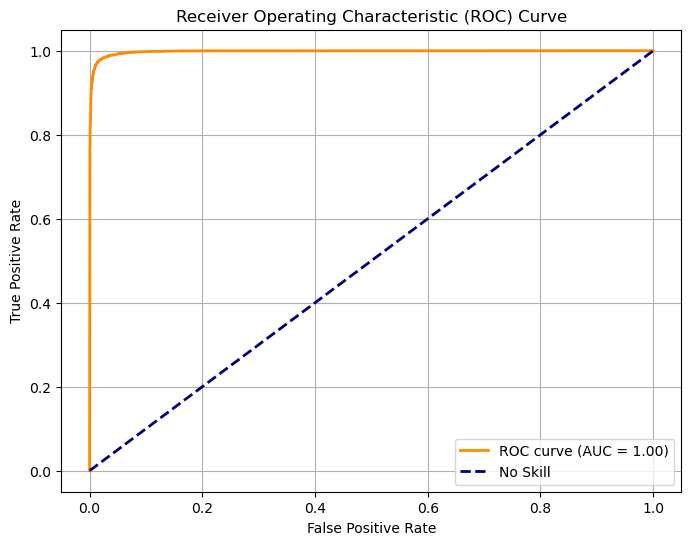

In [17]:
# AUC-ROC Curve
y_probs = model.predict(image_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, y_probs))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()